## 1.1

In [1]:
import numpy as np

In [3]:
cov = np.array([[.1, .02, .01],
                [.02, .11, .03],
                [.01, .03, .2]])

cov_inv = np.linalg.pinv(cov)

rho = np.array([.045, .003, .0285]).reshape(-1, 1)

e = np.array([[1],[1],[1]])

In [7]:
# P* Global Min Variance Portfolio
w = (np.linalg.pinv(cov).dot(e))/(e.T.dot(np.linalg.pinv(cov).dot(e)))
w.round(4)
(cov_inv@e)/(e.T@cov_inv@e)

array([[0.44946809],
       [0.35638298],
       [0.19414894]])

In [4]:
1/(e.T.dot(np.linalg.pinv(cov).dot(e))).round(3)

array([[0.0540161]])

In [10]:
np.sum(rho * w)
w.T@rho

array([[0.02682846]])

## 1.2

In [22]:
# https://www.math.ust.hk/~maykwok/courses/ma362/Topic2.pdf
a = e.T.dot(cov_inv).dot(e)
b = e.T.dot(cov_inv).dot(rho)
c = rho.T.dot(cov_inv).dot(rho)
delta = a*c - b**2

In [23]:
#P1
er_1 = rho[0]/3
lam_1 = (c-b*er_1)/delta
lam_2 = (a*er_1-b)/delta
er_1

array([0.015])

In [24]:
cov_inv@(lam_1*e + lam_2*rho)

array([[0.19278391],
       [0.65415429],
       [0.1530618 ]])

In [25]:
w_1 = cov_inv.dot((lam_1*e + lam_2*rho))
w_1

array([[0.19278391],
       [0.65415429],
       [0.1530618 ]])

In [26]:
#volatility
np.sqrt(w_1.T.dot(cov).dot(w_1))

array([[0.2590661]])

In [27]:
np.sum(rho * w_1)

0.014999999999999996

In [28]:
#P2
er_2 = rho[1] + rho[2]
lam_1 = (c-b*er_2)/delta
lam_2 = (a*er_2-b)/delta
er_2

array([0.0315])

In [29]:
w_2 = cov_inv.dot((lam_1*e + lam_2*rho))
w_2

array([[0.55084318],
       [0.23878088],
       [0.21037593]])

In [30]:
#volatility
np.sqrt(w_2.T.dot(cov).dot(w_2))

array([[0.23676816]])

In [31]:
np.sum(rho * w_2)

0.031499999999999986

## 1.3

In [32]:
#P3
er_3 = np.sum(rho)/3
er_3

0.0255

In [33]:
x = -0.006/-0.0165
w_3 = x*w_1 + (1-x)*w_2
w_3

array([[0.42063981],
       [0.38982576],
       [0.18953443]])

In [34]:
np.sqrt(w_3.T.dot(cov).dot(w_3))

array([[0.23276853]])

In [35]:
np.sum(rho * w_3)

0.025499999999999988

## 1.4

In [36]:
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [37]:
def get_ret_vol_sr(weights):
        """
        Calculates the returns, volatility, and sharpe of a portfolio with given weights
        """
        weights = np.array(weights)
        ret = weights.T@rho
        vol = np.sqrt(weights.T.dot(cov).dot(weights))
        sr = ret/vol
        return np.array([ret, vol, sr], dtype=object)


def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]


def opt_target_return(er):
    cons = ({'type':'eq', 'fun': lambda x: np.sum(x)-1},
            {'type':'eq', 'fun': lambda x: (get_ret_vol_sr(x)[0] - er)})

    bounds = tuple((0,1) for _ in range(3))
    init_guess = [1/3 for _ in range(3)]

    opt_results = opt.minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    return opt_results

In [54]:
from quadprog import solve_qp

P = cov
q = np.array([0,0,0]).reshape(3,)

A = np.concatenate((np.array([1,1,1]).reshape(-1, 1), rho), axis=1)
b = np.array([1, 0.015])

t = solve_qp(cov.astype(np.double), np.array([0,0,0]).astype(np.double), A.astype(np.double), b.astype(np.double))[0]
t.T@rho
# Ax = b
# 1*w1 + 1*w2 + 1*w3 = 1
# 0.045 * w1 + 0.003*w2 + 0.0285*w3 = er
# Kinda worked?

array([0.02682846])

In [56]:
from cvxopt import matrix, solvers

P = np.array(cov)
q = np.array([0]*len(rho)).reshape(len(rho),)

A = np.concatenate((np.ones(len(rho)).reshape(-1, 1), rho), axis=1).T
b = np.array([1, 0.015])

def quadprog(P, q, G=None, h=None, A=None, b=None):
    P, q = matrix(P), matrix(np.ones(P.shape[0]) * -1)

    if G is not None:
        G, h = matrix(G), matrix(h)

    if A is not None:
        A, b = matrix(A), matrix(b)

    sol = solvers.qp(P, q, G, h, A, b)

    return np.array(sol['x']).ravel()

quadprog(P=P, q=q, A=A, b=b)
# Did work

array([0.19278391, 0.65415429, 0.1530618 ])

In [38]:
#Portfolio 1
print(f"P1:\nCalculated weights: \n{w_1.round(4)}, \n\nOpt weights: \n{opt_target_return(er_1)['x'].reshape(-1, 1).round(4)}")

P1:
Calculated weights: 
[[0.1928]
 [0.6542]
 [0.1531]], 

Opt weights: 
[[0.1929]
 [0.6542]
 [0.1529]]


In [41]:
#Portfolio 2
print(f"P2:\nCalculated weights: \n{w_2.round(4)}, \n\nOpt weights: \n{opt_target_return(er_2)['x'].reshape(-1, 1).round(4)}")

P2:
Calculated weights: 
[[0.5508]
 [0.2388]
 [0.2104]], 

Opt weights: 
[[0.5509]
 [0.2388]
 [0.2102]]


In [42]:
#Portfolio 3
print(f"P3:\nCalculated weights: \n{w_3.round(4)}, \n\nOpt weights: \n{opt_target_return(er_3)['x'].reshape(-1, 1).round(4)}")

P3:
Calculated weights: 
[[0.4206]
 [0.3898]
 [0.1895]], 

Opt weights: 
[[0.4206]
 [0.3898]
 [0.1896]]


### Efficient Frontier

In [57]:
vols = []
rets = []
for i in np.arange(-5, 5, 0.01):
    w = i*w_1 + (1-i)*w_2
    t = get_ret_vol_sr(w)
    rets.append(t[0][0])
    vols.append(t[1][0])

In [59]:
# From class slides
delta = (rho.T.dot(cov_inv).dot(rho)) * (e.T.dot(cov_inv).dot(e)) - (rho.T.dot(cov_inv).dot(e))**2
A = rho.T.dot(cov_inv).dot(e)
B = rho.T.dot(cov_inv).dot(rho)
C = e.T.dot(cov_inv).dot(e)

asymp_1s = []
asymp_2s = []
vols_range = np.arange(0, np.max(vols), 0.001)
for sigma in vols_range:
    asymptote_1 = np.sqrt(delta/C)*sigma + (A/C)
    asymptote_2 = -np.sqrt(delta/C)*sigma + (A/C)
    
    asymp_1s.append(asymptote_1[0])
    asymp_2s.append(asymptote_2[0])

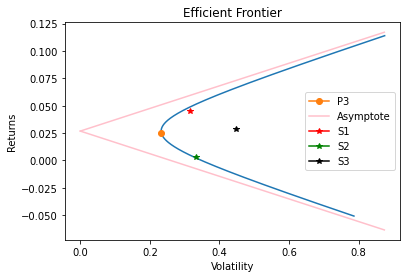

In [60]:
plt.plot(vols, rets)
plt.title("Efficient Frontier")
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.plot(get_ret_vol_sr(w_3)[1][0], get_ret_vol_sr(w_3)[0][0], marker="o", label="P3")
plt.plot(vols_range, asymp_1s, color="pink", label="Asymptote")
plt.plot(vols_range, asymp_2s, color="pink")
plt.plot(np.sqrt(cov[0][0]), rho[0], marker="*", color="red", label="S1")
plt.plot(np.sqrt(cov[1][1]), rho[1], marker="*", color="green", label="S2")
plt.plot(np.sqrt(cov[2][2]), rho[2], marker="*", color="black", label="S3")
plt.legend()
plt.savefig('problem14_ef.png')

In [27]:
get_ret_vol_sr([1,0,0])

array([array([0.045]), 0.31622776601683794, array([0.14230249])],
      dtype=object)

## 2.1

In [61]:
# https://quantatrisk.com/2014/05/16/asset-allocation-for-tangent-portfolio-with-risk-free-asset-in-python/
rho_0 = 0.006
w_tan = cov_inv@(rho-rho_0)
w_tan

array([[ 0.40509601],
       [-0.13146233],
       [ 0.11196455]])

In [64]:
w_tan = w_tan/np.sum(w_tan)
w_tan

array([[ 1.05056503],
       [-0.34093086],
       [ 0.29036583]])

In [65]:
tp_vol = np.sqrt(w_tan.T@cov@w_tan)

In [66]:
tp_ret = w_tan.T@rho

## 2.2

In [67]:
delta = (rho.T.dot(cov_inv).dot(rho)) * (e.T.dot(cov_inv).dot(e)) - (rho.T.dot(cov_inv).dot(e))**2
A = rho.T.dot(cov_inv).dot(e)
B = rho.T.dot(cov_inv).dot(rho)
C = e.T.dot(cov_inv).dot(e)
H = (rho-rho_0*e).T@cov_inv@(rho-rho_0*e)

asymp_1s_tan = []
asymp_2s_tan = []
vols_range = np.arange(0, np.max(vols), 0.001)
for sigma in vols_range:
    asymptote_1 = rho_0 + np.sqrt(H)*sigma
    asymptote_2 = rho_0 - np.sqrt(H)*sigma
    
    asymp_1s_tan.append(asymptote_1[0])
    asymp_2s_tan.append(asymptote_2[0])

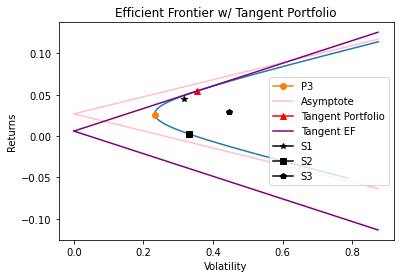

In [68]:
plt.plot(vols, rets)
plt.title("Efficient Frontier w/ Tangent Portfolio")
plt.xlabel("Volatility")
plt.ylabel("Returns")

plt.plot(get_ret_vol_sr(w_3)[1][0], get_ret_vol_sr(w_3)[0][0], marker="o", label="P3")

plt.plot(vols_range, asymp_1s, color="pink", label="Asymptote")
plt.plot(vols_range, asymp_2s, color="pink")

plt.plot(tp_vol, tp_ret, marker="^", color="red", label="Tangent Portfolio")
plt.plot(vols_range, asymp_1s_tan, color="purple", label="Tangent EF")
plt.plot(vols_range, asymp_2s_tan, color="purple")

plt.plot(np.sqrt(cov[0][0]), rho[0], marker="*", color="black", label="S1")
plt.plot(np.sqrt(cov[1][1]), rho[1], marker="s", color="black", label="S2")
plt.plot(np.sqrt(cov[2][2]), rho[2], marker="p", color="black", label="S3")

plt.legend()
plt.savefig('problem22_ef.png')

## 2.3

In [69]:
alpha = 0.0927
w_4 = (1-alpha)*w_tan

In [70]:
np.sqrt(w_4.T@cov@w_4)

array([[0.32186953]])

## 2.4

In [71]:
# Rearrange equation 43 from slides
er_5 = (np.sqrt(H)*0.16) + rho_0
er_5

array([[0.02788689]])

In [72]:
#0.0278 = alpha*0.006 + (1-alpha)*0.0545
alpha = 0.5487
w_5 = (1-alpha)*w_tan
w_5

array([[ 0.47412  ],
       [-0.1538621],
       [ 0.1310421]])

In [73]:
np.sqrt(w_5.T@cov@w_5)

array([[0.16010109]])

## 2.5

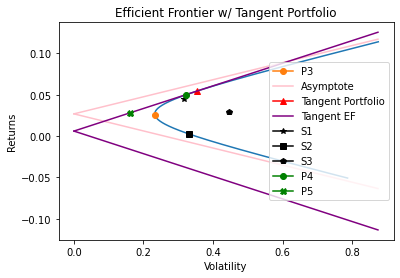

In [74]:
plt.plot(vols, rets)
plt.title("Efficient Frontier w/ Tangent Portfolio")
plt.xlabel("Volatility")
plt.ylabel("Returns")

plt.plot(get_ret_vol_sr(w_3)[1][0], get_ret_vol_sr(w_3)[0][0], marker="o", label="P3")

plt.plot(vols_range, asymp_1s, color="pink", label="Asymptote")
plt.plot(vols_range, asymp_2s, color="pink")

plt.plot(tp_vol, tp_ret, marker="^", color="red", label="Tangent Portfolio")
plt.plot(vols_range, asymp_1s_tan, color="purple", label="Tangent EF")
plt.plot(vols_range, asymp_2s_tan, color="purple")

plt.plot(np.sqrt(cov[0][0]), rho[0], marker="*", color="black", label="S1")
plt.plot(np.sqrt(cov[1][1]), rho[1], marker="s", color="black", label="S2")
plt.plot(np.sqrt(cov[2][2]), rho[2], marker="p", color="black", label="S3")

plt.plot((np.sqrt(w_4.T@cov@w_4)).round(4), 0.05, marker="o", color="green", label="P4")
plt.plot(.16, er_5, marker="X", color="green", label="P5")

plt.legend()
plt.savefig('problem25_ef.png')

## 3.1

In [75]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()

In [76]:
universe = ["FXE","EWJ", "GLD", "QQQ", "SHV", "DBA", "USO", "XBI","ILF","EPP", "FEZ"]

u_data = pdr.get_data_yahoo(["SPY"] + universe, start="2020-01-01", end="2021-03-30")["Adj Close"]
rets = np.log(u_data/u_data.shift(1)).dropna()

In [77]:
rets.head()

Symbols,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,EPP,FEZ
Date,,,,,,,,,,,,
2020-01-03,-0.007601,-0.000567,-0.011087,0.013181,-0.009202,0.000000,-0.011582,0.028474,-0.014040,-0.010100,-0.010316,-0.012929
2020-01-06,0.003808,0.002549,0.003541,0.010435,0.006423,-0.000091,0.002450,-0.001519,0.008639,-0.008154,0.002374,0.001717
2020-01-07,-0.002816,-0.004347,0.001682,0.003927,-0.000139,0.000181,0.002443,-0.002282,0.001592,-0.002635,-0.000647,-0.005653
2020-01-08,0.005315,-0.002940,0.000168,-0.007530,0.007488,0.000091,-0.004893,-0.036452,0.013584,-0.002936,0.004948,0.004918
2020-01-09,0.006758,-0.000190,0.007032,-0.005668,0.008438,0.000000,0.002450,-0.013519,0.002194,-0.008860,0.003642,0.004161


## 3.2

In [78]:
cov = rets.loc[:"2021-01-02"].cov()
cov

Symbols,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,EPP,FEZ
Symbols,,,,,,,,,,,,
SPY,0.000451,2.501352e-06,2.856588e-04,4.178932e-05,4.492571e-04,-1.292545e-06,8.720220e-05,0.000428,0.000428,0.000623,0.000463,0.000448
FXE,0.000003,2.219826e-05,7.104694e-06,1.871771e-05,-5.775365e-07,1.709721e-07,3.689203e-06,-0.000025,-0.000006,0.000013,0.000008,0.000018
EWJ,0.000286,7.104694e-06,2.617893e-04,3.210394e-05,2.699442e-04,-6.057176e-07,6.542797e-05,0.000205,0.000275,0.000433,0.000329,0.000335
GLD,0.000042,1.871771e-05,3.210394e-05,1.517652e-04,6.195338e-05,2.015856e-07,1.420433e-05,0.000002,0.000056,0.000034,0.000046,0.000052
QQQ,0.000449,-5.775365e-07,2.699442e-04,6.195338e-05,5.120639e-04,-1.240832e-06,8.622799e-05,0.000400,0.000458,0.000571,0.000442,0.000418
SHV,-0.000001,1.709721e-07,-6.057176e-07,2.015856e-07,-1.240832e-06,3.107402e-08,-2.298584e-07,-0.000003,-0.000001,-0.000002,-0.000001,-0.000001
DBA,0.000087,3.689203e-06,6.542797e-05,1.420433e-05,8.622799e-05,-2.298584e-07,8.256413e-05,0.000132,0.000091,0.000146,0.000096,0.000106
USO,0.000428,-2.542352e-05,2.050238e-04,2.061274e-06,4.000021e-04,-3.126653e-06,1.323763e-04,0.002155,0.000447,0.000763,0.000495,0.000471
XBI,0.000428,-5.786525e-06,2.749525e-04,5.635492e-05,4.579280e-04,-1.203170e-06,9.109467e-05,0.000447,0.000677,0.000556,0.000439,0.000431


In [79]:
beta_vec = cov.iloc[1:,0]/cov.iloc[0,0]
beta_vec

Symbols
FXE    0.005549
EWJ    0.633720
GLD    0.092708
QQQ    0.996655
SHV   -0.002867
DBA    0.193454
USO    0.949703
XBI    0.950241
ILF    1.382328
EPP    1.028135
FEZ    0.993915
Name: SPY, dtype: float64

In [80]:
rets = rets.drop("SPY", axis=1)
rets.head()

Symbols,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,EPP,FEZ
Date,,,,,,,,,,,
2020-01-03,-0.000567,-0.011087,0.013181,-0.009202,0.000000,-0.011582,0.028474,-0.014040,-0.010100,-0.010316,-0.012929
2020-01-06,0.002549,0.003541,0.010435,0.006423,-0.000091,0.002450,-0.001519,0.008639,-0.008154,0.002374,0.001717
2020-01-07,-0.004347,0.001682,0.003927,-0.000139,0.000181,0.002443,-0.002282,0.001592,-0.002635,-0.000647,-0.005653
2020-01-08,-0.002940,0.000168,-0.007530,0.007488,0.000091,-0.004893,-0.036452,0.013584,-0.002936,0.004948,0.004918
2020-01-09,-0.000190,0.007032,-0.005668,0.008438,0.000000,0.002450,-0.013519,0.002194,-0.008860,0.003642,0.004161


In [82]:
cov = rets.loc[:"2021-01-02"].cov()

def min_vol(w, cov_mat):
    
    w = np.array(w)
    return w.T@cov_mat@w

def calc_weights(B_t, beta_vec, cov_mat):
    
    cons = ({'type':'eq', 'fun': lambda x: np.sum(x)-1},
            {'type':'eq', 'fun': lambda x: (beta_vec.T@x - B_t)})

    init_guess = [1/len(cov_mat.columns) for _ in range(len(cov_mat.columns))]

    opt_results = opt.minimize(min_vol, init_guess, method='SLSQP', constraints=cons, args=(cov_mat,))
    return opt_results

In [84]:
P_B1 = calc_weights(0.5, beta_vec, cov).x
P_B2 = calc_weights(1.5, beta_vec, cov).x

array([-0.13248006,  0.08306886, -0.10259304,  0.20764897, -0.13536082,
       -0.06802479,  0.1911771 ,  0.19165619,  0.33987925,  0.2183891 ,
        0.20663924])

In [85]:
# 1 = lam*(beta_vect.T@P_B1) + (1-lam)*(beta_vect.T@P_B2)
lam = 0.5
P_B3 = lam*(P_B1) + (1-lam)*(P_B2)
P_B3.round(3)

array([-0.   ,  0.088,  0.012,  0.138, -0.001,  0.026,  0.132,  0.132,
        0.192,  0.143,  0.138])

##### 

## 3.3
### a

In [86]:
data = pdr.get_data_yahoo(["SPY", "AAPL"], start="2020-01-01", end="2021-03-30")["Adj Close"]
rets2 = np.log(data/data.shift(1)).dropna()

In [87]:
cov2 = rets2.loc[:"2021-01-02"].cov()
cov2

Symbols,SPY,AAPL
Symbols,,
SPY,0.000451,0.000520
AAPL,0.000520,0.000866


In [88]:
B_A = cov2.iloc[1:,0]/cov2.iloc[0,0]
B_A

Symbols
AAPL    1.153873
Name: SPY, dtype: float64

### b

In [89]:
P_BA = calc_weights(B_A, beta_vec, cov).x
P_BA

array([-0.04079075,  0.08630269, -0.02317688,  0.15977637, -0.04248632,
       -0.00279515,  0.1499161 ,  0.15031932,  0.23769844,  0.16608374,
        0.15915245])

In [90]:
rho1 = rets.loc[:"2021-01-02"].mean()
rho2 = rets2.loc[:"2021-01-02", "AAPL"].mean()

In [91]:
# Long Apple 50%, Short Beta Portfolio 50%
hedge_port_w = np.append((P_BA* -0.5), 0.5)
rho = np.append(rho1, rho2)
(hedge_port_w.T@rho)*100

0.1282285119458973

In [92]:
# Hedged Portfolio Beta
(hedge_port_w.T@np.append(beta_vec, B_A)).round(3)

0.0

### c

In [93]:
v_data = pdr.get_data_yahoo(["AAPL"] + universe, start="2020-01-01", end="2021-03-30")["Adj Close"]
v_rets = np.log(v_data/v_data.shift(1)).dropna()
v_cov = v_rets.cov()
v_cov

Symbols,AAPL,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,EPP,FEZ
Symbols,,,,,,,,,,,,
AAPL,0.000784,2.382575e-06,2.502146e-04,6.419632e-05,5.399652e-04,-1.082150e-06,7.971510e-05,0.000381,4.517523e-04,0.000538,0.000419,0.000376
FXE,0.000002,2.108474e-05,7.609077e-06,1.960376e-05,1.866238e-06,1.551167e-07,5.077818e-06,-0.000018,-8.431568e-07,0.000015,0.000009,0.000018
EWJ,0.000250,7.609077e-06,2.296743e-04,2.965991e-05,2.339027e-04,-4.875494e-07,5.496560e-05,0.000176,2.457470e-04,0.000370,0.000280,0.000283
GLD,0.000064,1.960376e-05,2.965991e-05,1.444930e-04,5.746183e-05,1.903866e-07,1.511318e-05,0.000004,5.871248e-05,0.000035,0.000043,0.000047
QQQ,0.000540,1.866238e-06,2.339027e-04,5.746183e-05,4.600212e-04,-9.908576e-07,7.389804e-05,0.000334,4.198110e-04,0.000493,0.000377,0.000355
SHV,-0.000001,1.551167e-07,-4.875494e-07,1.903866e-07,-9.908576e-07,2.599597e-08,-1.852656e-07,-0.000003,-9.224578e-07,-0.000002,-0.000001,-0.000001
DBA,0.000080,5.077818e-06,5.496560e-05,1.511318e-05,7.389804e-05,-1.852656e-07,7.664948e-05,0.000123,7.983189e-05,0.000123,0.000082,0.000089
USO,0.000381,-1.816965e-05,1.755078e-04,3.639581e-06,3.335903e-04,-2.556352e-06,1.226882e-04,0.001855,3.747746e-04,0.000637,0.000416,0.000391
XBI,0.000452,-8.431568e-07,2.457470e-04,5.871248e-05,4.198110e-04,-9.224578e-07,7.983189e-05,0.000375,6.729501e-04,0.000496,0.000376,0.000369


In [94]:
v_beta_vec = np.append(B_A, beta_vec)
P_BN = calc_weights(0, v_beta_vec, v_cov).x

In [95]:
(P_BN.T@v_beta_vec).round()

-0.0

In [96]:
P_BN.T@v_rets.mean()

0.0001506074751241534

In [97]:
P_BN

array([-0.03513274,  0.26343776,  0.10011013,  0.24075131,  0.0057483 ,
        0.26563652,  0.21456509,  0.01770927,  0.01775735, -0.09458224,
       -0.00244932,  0.00644857])